### Parameter recovery code - mainly taken from: 
https://github.com/hcp4715/dockerHDDM/blob/master/dockerHDDMTutorial/Parameter_recovery.ipynb

### this is code for the parameter recovery of the combined (ESEE) model

In [1]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import statsmodels.api as sm
import re

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az

print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


- model for ES and EE: 
v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(OVcate)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'OVcate'}
- at the group level: a, AttentionW, intercept

- model for ESEE:

v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(phase)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'phase'}
- at the group level: a, AttentionW, intercept

### reg_plot_with_corr does this: It plots a scatterplot with a regression line, and annotates the plot with:

- Pearson correlation coefficient (r)

- p-value

- Regression intercept (β₀)

- Regression slope (β₁)

In [2]:
# paths
model_dir = "/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


chain0 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ESEE_4_0.nc")
chain1 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ESEE_4_1.nc")
chain2 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ESEE_4_2.nc")
chain3 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ESEE_4_3.nc")
chain4 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ESEE_4_4.nc")



In [3]:
esee5_infdata = az.concat([chain0,chain1, chain3,chain2, chain4], dim="chain")


In [4]:

def regplot_with_corr(
    data=None,
    x="x",
    y="y",
    cor_anonot=True,
    reg_anonot=True,
    annot_kws={
        "fontsize": 8,
        "xy": (0.95, 0.05),
        "ha": 'right',
        "va": 'bottom'
    },
    scatter_kws={
        's': 40,
        "alpha": 0.4
    },
    ax=None,
    **kwargs
):
    """

    Example:
    --------
    >>> Example usage
    >>> import pandas as pd
    >>> data = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [2, 3, 5, 7, 11]})
    >>> regplot_with_corr(data)
    >>> plt.show()
    """
    if ax is None:
        ax = plt.gca()
    if data is not None:
        data_x = data[x]
        data_y = data[y]
    else: 
        data_x = x
        data_y = y

    # Plot regression line and scatter plot
    sns.regplot(
        x=data_x,
        y=data_y,
        ci=None if len(np.unique(data_y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""
    if cor_anonot:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(data_x, data_y)
        # if np.isnan(correlation):
        #     correlation = 0
        # if np.isnan(p_value):
        #     p_value = 1
        p_str = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        annot_text += f"$r={correlation:.2f}$\n${p_str}$"

    if reg_anonot:
        # Calculate regression coefficients
        X = sm.add_constant(data_x)  # Adds a constant term to the predictor
        model = sm.OLS(data_y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    # Annotate the plot with correlation, p-value, intercept, and slope
    if annot_text != "":
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(
                boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'
            )
        )
    
    return ax




def az_summary(infdata=None, half_a=False, param_names_order=None, **kwargs):

    param_df = az.summary(infdata, kind="stats",
                            **kwargs).reset_index(names="param_name")
    # col_values = ['mean', 'sd', "hdi_3%", "hdi_97%"]
    col_values = list(param_df.columns[1:5])

    pattern = r'(.*)_subj\.(\d+)'

    param_df[['param',
                'subj_idx']] = param_df['param_name'].str.extract(pattern)
    # param_df['param'] = param_df['param'].apply(lambda x: f'${x}$')
    param_df = param_df.dropna(subset=['subj_idx'])
    param_df['subj_idx'] = param_df['subj_idx'].astype(int)

    if half_a:
        param_df.loc[param_df['param'] == 'a',
                        col_values] = param_df.loc[param_df['param'] == 'a',
                                                col_values] / 2

    param_df = param_df.pivot(
        index='subj_idx', columns='param', values=col_values
    )

    if param_names_order is not None:
        new_index = pd.MultiIndex.from_tuples(
            [
                (level_0, param) for level_0 in col_values
                for param in param_names_order
            ],
            names=[None, 'param']
        )
        param_df = param_df.reindex(columns=new_index)

    param_df.reset_index(inplace=True)
    param_df.columns.names = [None, None]

    return param_df

In [6]:
summary_df = az_summary(esee5_infdata)['mean']
print(summary_df.columns.tolist())


['t', 'v_AttentionW', 'v_InattentionW:C(phase)[EE]', 'v_InattentionW:C(phase)[ES]', 'v_Intercept']


In [7]:
esee5_infdata


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [8]:

# load the model
data_ESEE_5 = esee5_infdata.observed_data.to_dataframe().reset_index(drop=True)

df_ind_summary = data_ESEE_5.groupby(['subj_idx','phase'])['rt'].describe().reset_index()
df_ind_summary = df_ind_summary.set_index('subj_idx').join(
     az_summary(esee5_infdata)['mean'].reset_index(names=['subj_idx']).set_index('subj_idx')
     ).reset_index()
df_ind_summary.head()

,subj_idx,phase,count,mean,std,min,25%,50%,75%,max,t,v_AttentionW,v_InattentionW:C(phase)[EE],v_InattentionW:C(phase)[ES],v_Intercept
0,1,EE,140.0,0.718455,1.341150,-2.115764,0.588795,0.766153,1.051225,12.690050,0.363,0.017,0.016,0.017,0.441
1,1,ES,360.0,0.802948,1.271673,-4.820869,0.623434,0.915099,1.382865,4.493053,0.363,0.017,0.016,0.017,0.441
2,3,EE,135.0,0.858349,1.361846,-3.277853,0.650583,0.993805,1.608112,6.017033,0.476,0.017,-0.008,0.023,0.282
3,3,ES,357.0,1.014766,1.328602,-4.877002,0.710945,0.955204,1.452365,8.434638,0.476,0.017,-0.008,0.023,0.282
4,4,EE,117.0,0.201378,1.500127,-4.487350,-1.067448,0.790902,1.402409,2.991165,0.461,0.020,0.017,0.020,0.376


In [9]:
print(esee5_infdata.groups())


['posterior', 'posterior_predictive', 'log_likelihood', 'observed_data']


In [10]:
def az_summary_group(infdata, **kwargs):
    summary_df = az.summary(infdata, kind="stats", **kwargs).reset_index()
    param_col = 'index' if 'index' in summary_df.columns else 'param_name'
    return summary_df.set_index(param_col)["mean"]

In [11]:
group_params = az_summary_group(esee5_infdata)
print(group_params.index.tolist())


['a(EE)', 'a(ES)', 'a_std', 'a_subj(EE).1', 'a_subj(EE).3', 'a_subj(EE).4', 'a_subj(EE).5', 'a_subj(EE).7', 'a_subj(EE).8', 'a_subj(EE).10', 'a_subj(EE).11', 'a_subj(EE).12', 'a_subj(EE).13', 'a_subj(EE).15', 'a_subj(EE).16', 'a_subj(EE).17', 'a_subj(EE).19', 'a_subj(EE).21', 'a_subj(EE).22', 'a_subj(EE).23', 'a_subj(EE).24', 'a_subj(EE).25', 'a_subj(EE).27', 'a_subj(ES).1', 'a_subj(ES).3', 'a_subj(ES).4', 'a_subj(ES).5', 'a_subj(ES).7', 'a_subj(ES).8', 'a_subj(ES).10', 'a_subj(ES).11', 'a_subj(ES).12', 'a_subj(ES).13', 'a_subj(ES).15', 'a_subj(ES).16', 'a_subj(ES).17', 'a_subj(ES).19', 'a_subj(ES).21', 'a_subj(ES).22', 'a_subj(ES).23', 'a_subj(ES).24', 'a_subj(ES).25', 'a_subj(ES).27', 't', 't_std', 't_subj.1', 't_subj.3', 't_subj.4', 't_subj.5', 't_subj.7', 't_subj.8', 't_subj.10', 't_subj.11', 't_subj.12', 't_subj.13', 't_subj.15', 't_subj.16', 't_subj.17', 't_subj.19', 't_subj.21', 't_subj.22', 't_subj.23', 't_subj.24', 't_subj.25', 't_subj.27', 'v_Intercept', 'v_Intercept_std', 'v

In [12]:
# get all group and subject-level parameters 
group_params = az.summary(esee5_infdata, var_names=['~subj', '~std'], filter_vars='regex')
subject_params = az_summary(esee5_infdata)['mean'] 

#mapping of subject-specific t parameters (non-decision time)
a_params = {}
for param in group_params.index:
    if param.startswith('a_subj'):
        # get components 't_subj(high).2' -> (2, 'high', value)
        parts = param.split(')')
        phase_level = parts[0].split('(')[1]
        subj_id = int(parts[1].split('.')[1])
        if subj_id not in a_params:
            a_params[subj_id] = {}
        a_params[subj_id][phase_level] = group_params.loc[param, 'mean']
        

# data_EE_5 -> trial‐by‐trial data from model
# df_ind_summary -> a subject×OVcate summary with "a", "v_Intercept", "v_AttentionW", "v_InattentionW:C(OVcate)[{ov}]", "count", etc.
# group_params -> group-level summary from az.summary(ee5_infdata, var_names=['~subj', '~std'], filter_vars='regex')
# t_params -> dictionary mapping subject IDs to their condition-specific t values

# build a sim_data that uses original trial-level predictors
sim_data = pd.DataFrame()

for (subj, phases), trial_group in data_ESEE_5.groupby(['subj_idx','phase']):
    
    j = df_ind_summary[(df_ind_summary['subj_idx'] == subj) & (df_ind_summary['phase'] == phases)].iloc[0]
    
    # Get the estimated parameters from origina model
    t_val = j["t"]
    v_int = j["v_Intercept"]
    v_att = j["v_AttentionW"]
    v_inatt = j[f"v_InattentionW:C(phase)[{phases}]"]
    
    # from t params mapping get non-dec time for particular subject
    try:
        a_val = a_params[int(subj)][phases]
    except KeyError:
        a_val = group_params.loc[f'a({phases})', 'mean']
    
    # for each trial for each subject and condition use actual AttentionW and InattentionW
    for idx, trial in trial_group.iterrows():
        att_val = trial["AttentionW"]      
        inatt_val = trial["InattentionW"] 
        
        # trial-by trial drift rate (not 100 sure)
        v_trial = v_int + v_att * att_val + v_inatt * inatt_val
        
        # 1 sim per trial
        sim_trial, _ = hddm.generate.gen_rand_data(
            {"v": v_trial, "a": a_val, "t": t_val},
            size=1,
            subjs=1,
        )
        sim_trial["subj_idx"] = subj
        sim_trial["phase"] = phases
        sim_trial["AttentionW"] = att_val
        sim_trial["InattentionW"] = inatt_val
        sim_data = pd.concat([sim_data, sim_trial], ignore_index=True)

if 'condition' in sim_data.columns:
    sim_data.drop('condition', axis=1, inplace=True)

# Check
print(sim_data.head(10))
print("\nUnique subjects in simulation:", sim_data['subj_idx'].nunique())
print("phase counts in simulation:\n", sim_data['phase'].value_counts())

print(sim_data.to_string())


      rt  response  subj_idx phase  AttentionW  InattentionW
0  1.571       1.0         1    EE      17.688         2.312
1  0.583       1.0         1    EE      52.634        -2.634
2  1.026       1.0         1    EE      49.774         0.226
3  1.020       1.0         1    EE      51.754        -1.754
4  0.499       1.0         1    EE      12.101        57.899
5  0.628       0.0         1    EE      43.040         6.960
6  0.479       1.0         1    EE      21.261        18.739
7  1.790       0.0         1    EE      19.649        -9.649
8  1.360       0.0         1    EE      17.615        12.385
9  0.561       1.0         1    EE       3.636        16.364

Unique subjects in simulation: 20
phase counts in simulation:
 phase
ES    6548
EE    2363
Name: count, dtype: int64
         rt  response  subj_idx phase  AttentionW  InattentionW
0     1.571       1.0         1    EE      17.688         2.312
1     0.583       1.0         1    EE      52.634        -2.634
2     1.026       1

In [ ]:
print("\nUnique subjects in simulation:", sim_data['subj_idx'].nunique())


In [24]:
print(sim_data.to_string())


         rt  response  subj_idx phase  AttentionW  InattentionW
0     1.062       1.0         2    EE      20.265        -0.265
1     0.727       1.0         2    EE      22.051        27.949
2     0.521       1.0         2    EE     -16.391        26.391
3     1.500       1.0         2    EE      10.467        -0.467
4     0.989       1.0         2    EE      39.064        20.936
5     1.365       1.0         2    EE     -41.129        61.129
6     1.207       1.0         2    EE      43.288         6.712
7     0.832       1.0         2    EE      14.662         5.338
8     0.629       1.0         2    EE      40.610         9.390
9     0.668       1.0         2    EE      16.224        -6.224
10    0.884       1.0         2    EE      26.496         3.504
11    1.033       1.0         2    EE      19.238        30.762
12    0.625       1.0         2    EE      27.980        12.020
13    0.934       1.0         2    EE      42.334         7.666
14    0.922       1.0         2    EE   

In [13]:
sim_data = sim_data[sim_data['subj_idx'] < 20]


In [14]:
print(sim_data[['subj_idx', 'phase', 'rt', 'response']].head())
print("\nUnique subjects:", sim_data['subj_idx'].nunique())
print("phase counts:\n", sim_data['phase'].value_counts())

   subj_idx phase     rt  response
0         1    EE  1.571       1.0
1         1    EE  0.583       1.0
2         1    EE  1.026       1.0
3         1    EE  1.020       1.0
4         1    EE  0.499       1.0

Unique subjects: 14
phase counts:
 phase
ES    4716
EE    1753
Name: count, dtype: int64


In [15]:
sim_data = sim_data[sim_data['subj_idx'] < 20]

def run_sampling(model, model_db_name, progress_bar=True):
    model.find_starting_values()
    result = model.sample(
        2000,                 
        burn=100,            
        dbname=model_db_name,
        db='pickle',        
        return_infdata=True, 
        loglike=True,
        ppc=True
    )
    if isinstance(result, tuple):
        model_out = result[0]
        infdata = result[1]
        return model_out, infdata
    else:
        return model, result

v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(phase)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'a': 'phase'}

m_recovery = hddm.HDDMRegressor(
    sim_data,             
    reg_descr,             
    depends_on=depends_on,
    include=['a', 't', 'v'], 
    p_outlier=0.05,
    group_only_regressors=False,
    keep_regressor_trace=True
)

model_db_name = os.path.join(model_dir, "mESEE_4_recovery")
m_recovery, m_recovery_infdata = run_sampling(m_recovery, model_db_name, progress_bar=False)

# saving inference data object
az.to_netcdf(m_recovery_infdata, os.path.join(model_dir, "mESEE_4_recovery.nc"))

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 874.8 sechddm sampling elpased time:  876.87 s
Start converting to InferenceData...
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 132.069 seconds
Start generating posterior prediction...
The time of generating PPC took 33.259 seconds


'/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/mESEE_4_recovery.nc'

In [17]:
# loading inference data from the .nc file
model_dir = "/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV"
recovered_nc = os.path.join(model_dir, "mESEE_4_recovery.nc")
m_recovery_infdata = az.from_netcdf(recovered_nc)


In [18]:
fig_dir = "/home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ESEE_4/diagnostics"

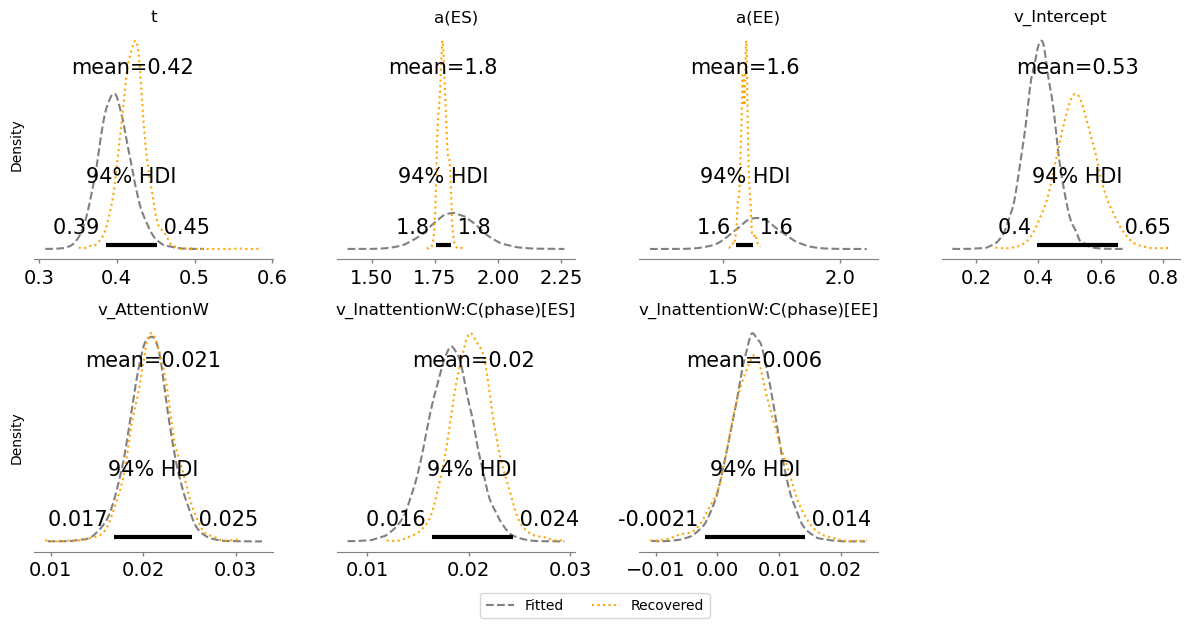

In [19]:
param_list = [
    't',
    'a(ES)', 'a(EE)',
    'v_Intercept',
    'v_AttentionW',
    'v_InattentionW:C(phase)[ES]',
    'v_InattentionW:C(phase)[EE]',
]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()


for i, param in enumerate(param_list):
    # plot posterior of the fitted model (grey for the ESEE)
    az.plot_posterior(
        esee5_infdata.posterior[param],
        ax=ax[i],
        color="grey",
        linestyle="dashed",
        label="Fitted",
        hdi_prob='hide',
        point_estimate=None
    )
    # recovered posterior
    az.plot_posterior(
        m_recovery_infdata.posterior[param],
        ax=ax[i],
        color="orange",
        linestyle="dotted",
        label="Recovered"
    )
    ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
    ax[i].set_title(param)
    if i == 0:
        handles, labels = ax[0].get_legend_handles_labels()
    if ax[i].get_legend():
        ax[i].legend_.remove()

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plot_path = os.path.join(fig_dir, "Posterior_dens_fitted_recov.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

plt.show()


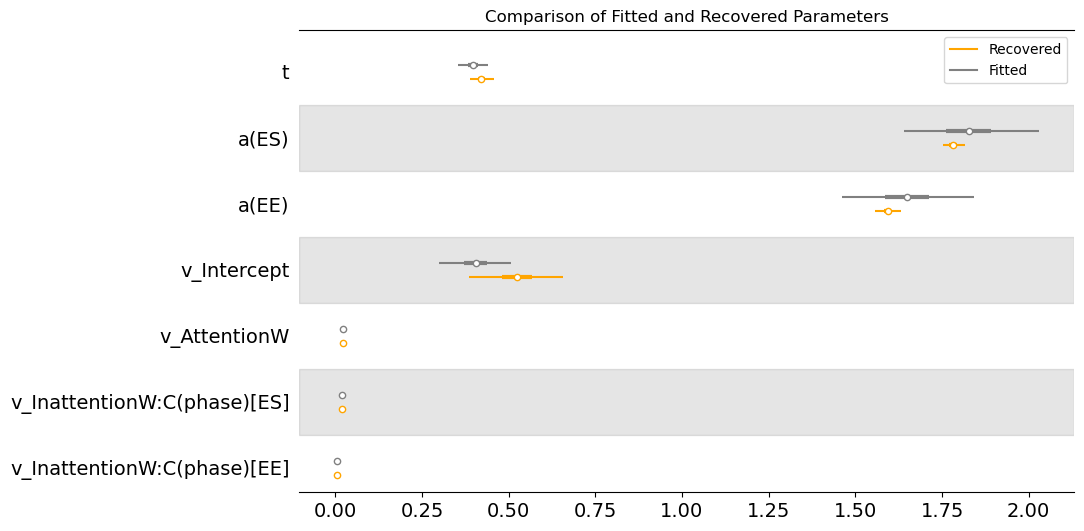

In [21]:
# forest plot for group-level parameters
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    [esee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    hdi_prob=0.95,
    colors=["gray", "orange"],
    ax=ax
)
ax.set_title("Comparison of Fitted and Recovered Parameters")

plot_path2 = os.path.join(fig_dir, "Compa_fitted_recov.png")

plt.savefig(plot_path2, dpi=300, bbox_inches='tight')

plt.show()



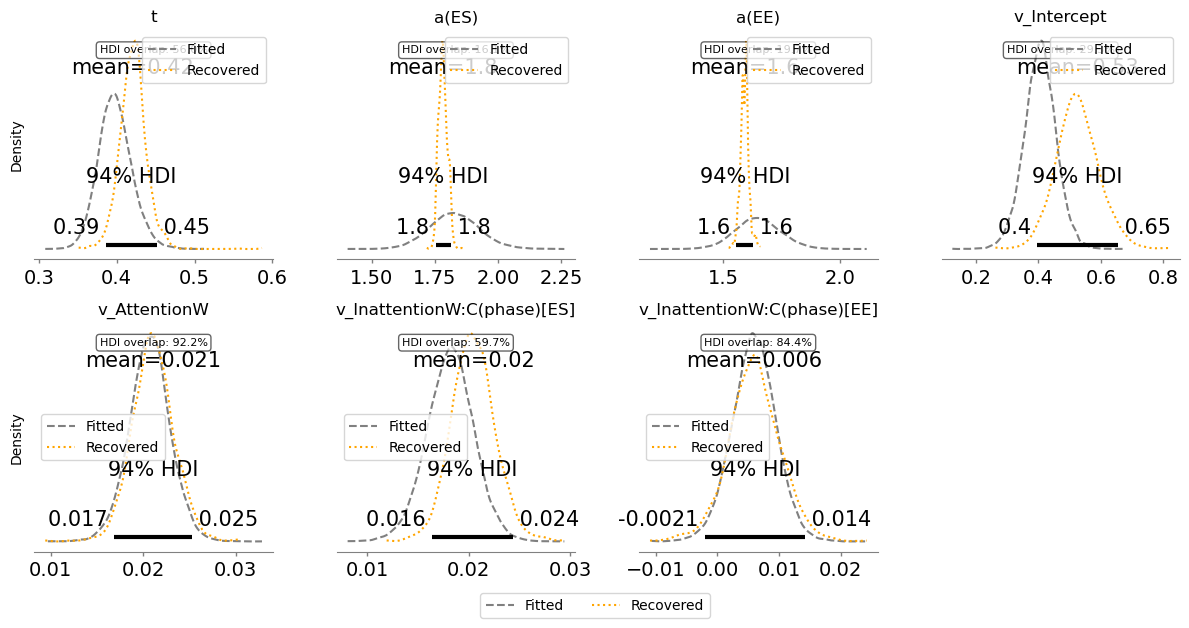


 HDI Overlap:
t                                       : 56.0% HDI overlap
a(ES)                                   : 16.1% HDI overlap
a(EE)                                   : 19.7% HDI overlap
v_Intercept                             : 29.3% HDI overlap
v_AttentionW                            : 92.2% HDI overlap
v_InattentionW:C(phase)[ES]             : 59.7% HDI overlap
v_InattentionW:C(phase)[EE]             : 84.4% HDI overlap


In [22]:
# qunatifiying how similar recovered and fitted posteriors are using HDI

def hdi_overlap(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the percent overlap of the HDIs between two posterior distributions
    """
    hdi1 = az.hdi(idata1.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    hdi2 = az.hdi(idata2.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    lower1, upper1 = hdi1.min(), hdi1.max()
    lower2, upper2 = hdi2.min(), hdi2.max()
    overlap = max(0, min(upper1, upper2) - max(lower1, lower2))
    total_range = max(upper1, upper2) - min(lower1, lower2)
    return overlap / total_range if total_range > 0 else 0

param_list = [
    't',
    'a(ES)', 'a(EE)',
    'v_Intercept',
    'v_AttentionW',
    'v_InattentionW:C(phase)[ES]',
    'v_InattentionW:C(phase)[EE]',
]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols
f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

hdi_results = []

for i, param in enumerate(param_list):
    try:
        # fitted posterior
        az.plot_posterior(
            esee5_infdata.posterior[param],
            ax=ax[i],
            color="grey",
            linestyle="dashed",
            label="Fitted",
            hdi_prob='hide',
            point_estimate=None
        )

        # recovered posterior
        az.plot_posterior(
            m_recovery_infdata.posterior[param],
            ax=ax[i],
            color="orange",
            linestyle="dotted",
            label="Recovered"
        )

        ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
        ax[i].set_title(param)

        # get HDI overlap
        hdi_ol = hdi_overlap(esee5_infdata, m_recovery_infdata, param)
        hdi_results.append((param, hdi_ol))
        ax[i].annotate(f"HDI overlap: {hdi_ol:.1%}", xy=(0.5, 0.9), xycoords='axes fraction',
                       ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

    except Exception as e:
        print(f"Could not process param '{param}': {e}")
        ax[i].axis('off')

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()

# HDI overlaps
print("\n HDI Overlap:")
for param, ol in hdi_results:
    print(f"{param:<40}: {ol:.1%} HDI overlap")


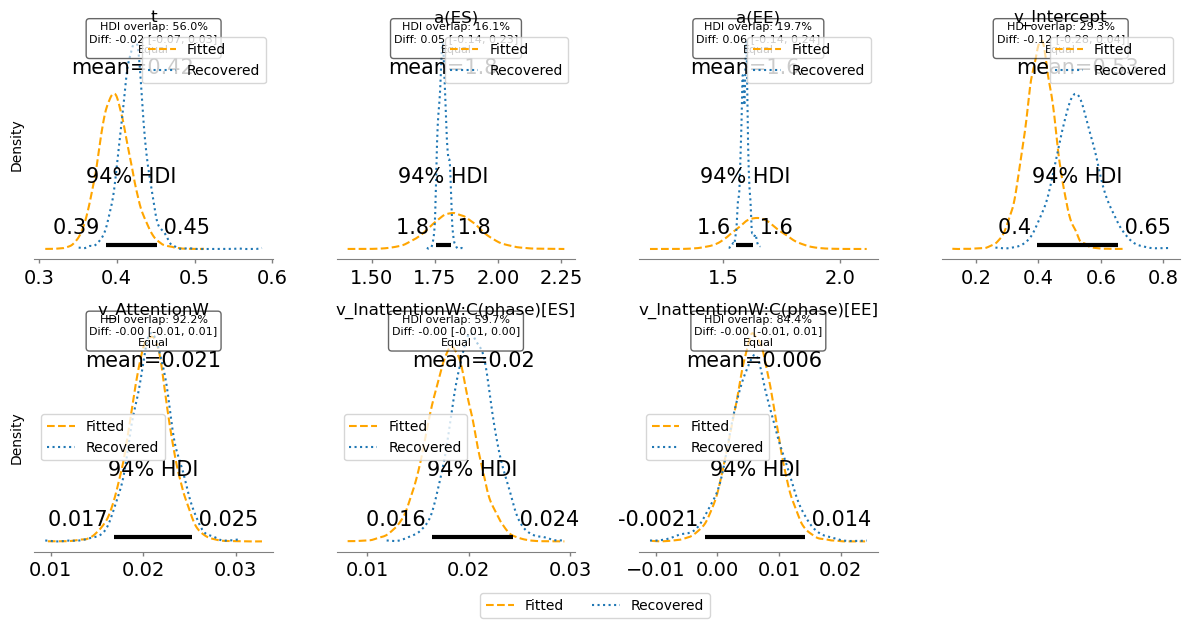

Summary exported to /home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ESEE_4/diagnostics/parameter_recovery_summary.csv
                     Parameter  HDI_Overlap               Diff_Mean   
0                            t     0.559898    -0.02362509225245787  \
1                        a(ES)     0.161199     0.05015228371782757   
2                        a(EE)     0.196515     0.06069358821636084   
3                  v_Intercept     0.292540    -0.12176016753230981   
4                 v_AttentionW     0.921543  -0.0003735281121610681   
5  v_InattentionW:C(phase)[ES]     0.597152   -0.002196867036752365   
6  v_InattentionW:C(phase)[EE]     0.843666  -7.076018947592924e-05   

   Diff_Lower  Diff_Upper  Equal  
0   -0.072215    0.032311   True  
1   -0.142805    0.228274   True  
2   -0.138995    0.238241   True  
3   -0.282102    0.039237   True  
4   -0.006139    0.006036   True  
5   -0.008016    0.003602   True  
6   -0.011320    0.010822   True  


In [23]:
def hdi_overlap(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the percent overlap of the HDIs between two posterior distributions
    """
    hdi1 = az.hdi(idata1.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    hdi2 = az.hdi(idata2.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    lower1, upper1 = hdi1.min(), hdi1.max()
    lower2, upper2 = hdi2.min(), hdi2.max()
    overlap = max(0, min(upper1, upper2) - max(lower1, lower2))
    total_range = max(upper1, upper2) - min(lower1, lower2)
    return overlap / total_range if total_range > 0 else 0

def difference_hdi(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the posterior difference (fitted minus recovered) for a parameter,
    then calculate the mean difference and its HDI
    
    Returns:
        diff_mean: Mean difference
        diff_lower: Lower bound of the HDI
        diff_upper: Upper bound of the HDI
        equal: Boolean; True if the HDI includes 0 (interpreted as "Equal")
    """
    diff = idata1.posterior[var_name] - idata2.posterior[var_name]
    hdi_diff = az.hdi(diff, hdi_prob=hdi_prob).to_array().values
    lower, upper = hdi_diff.min(), hdi_diff.max()
    diff_mean = diff.mean().values
    equal = (lower <= 0) and (upper >= 0)
    return diff_mean, lower, upper, equal

param_list = [
    't',
    'a(ES)', 'a(EE)',
    'v_Intercept',
    'v_AttentionW',
    'v_InattentionW:C(phase)[ES]',
    'v_InattentionW:C(phase)[EE]',
]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

summary_data = []

for i, param in enumerate(param_list):
    try:
        az.plot_posterior(
            esee5_infdata.posterior[param],
            ax=ax[i],
            color="orange",
            linestyle="dashed",
            label="Fitted",
            hdi_prob='hide',
            point_estimate=None
        )
        az.plot_posterior(
            m_recovery_infdata.posterior[param],
            ax=ax[i],
            linestyle="dotted",
            label="Recovered"
        )
        ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
        ax[i].set_title(param)
        
        hdi_ol = hdi_overlap(esee5_infdata, m_recovery_infdata, param)
        diff_mean, diff_lower, diff_upper, equal = difference_hdi(esee5_infdata, m_recovery_infdata, param)
        equality_str = "Equal" if equal else "Not Equal"
        
        annotation = (f"HDI overlap: {hdi_ol:.1%}\n"
                      f"Diff: {diff_mean:.2f} [{diff_lower:.2f}, {diff_upper:.2f}]\n"
                      f"{equality_str}")
        ax[i].annotate(annotation, xy=(0.5, 0.9), xycoords='axes fraction',
                       ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))
        
        summary_data.append({
            'Parameter': param,
            'HDI_Overlap': hdi_ol,
            'Diff_Mean': diff_mean,
            'Diff_Lower': diff_lower,
            'Diff_Upper': diff_upper,
            'Equal': equal
        })
    except Exception as e:
        print(f"Could not process param '{param}': {e}")
        ax[i].axis('off')

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_data)
csv_filename = "/home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ESEE_4/diagnostics/parameter_recovery_summary.csv"
summary_df.to_csv(csv_filename, index=False)
print(f"Summary exported to {csv_filename}")
print(summary_df)


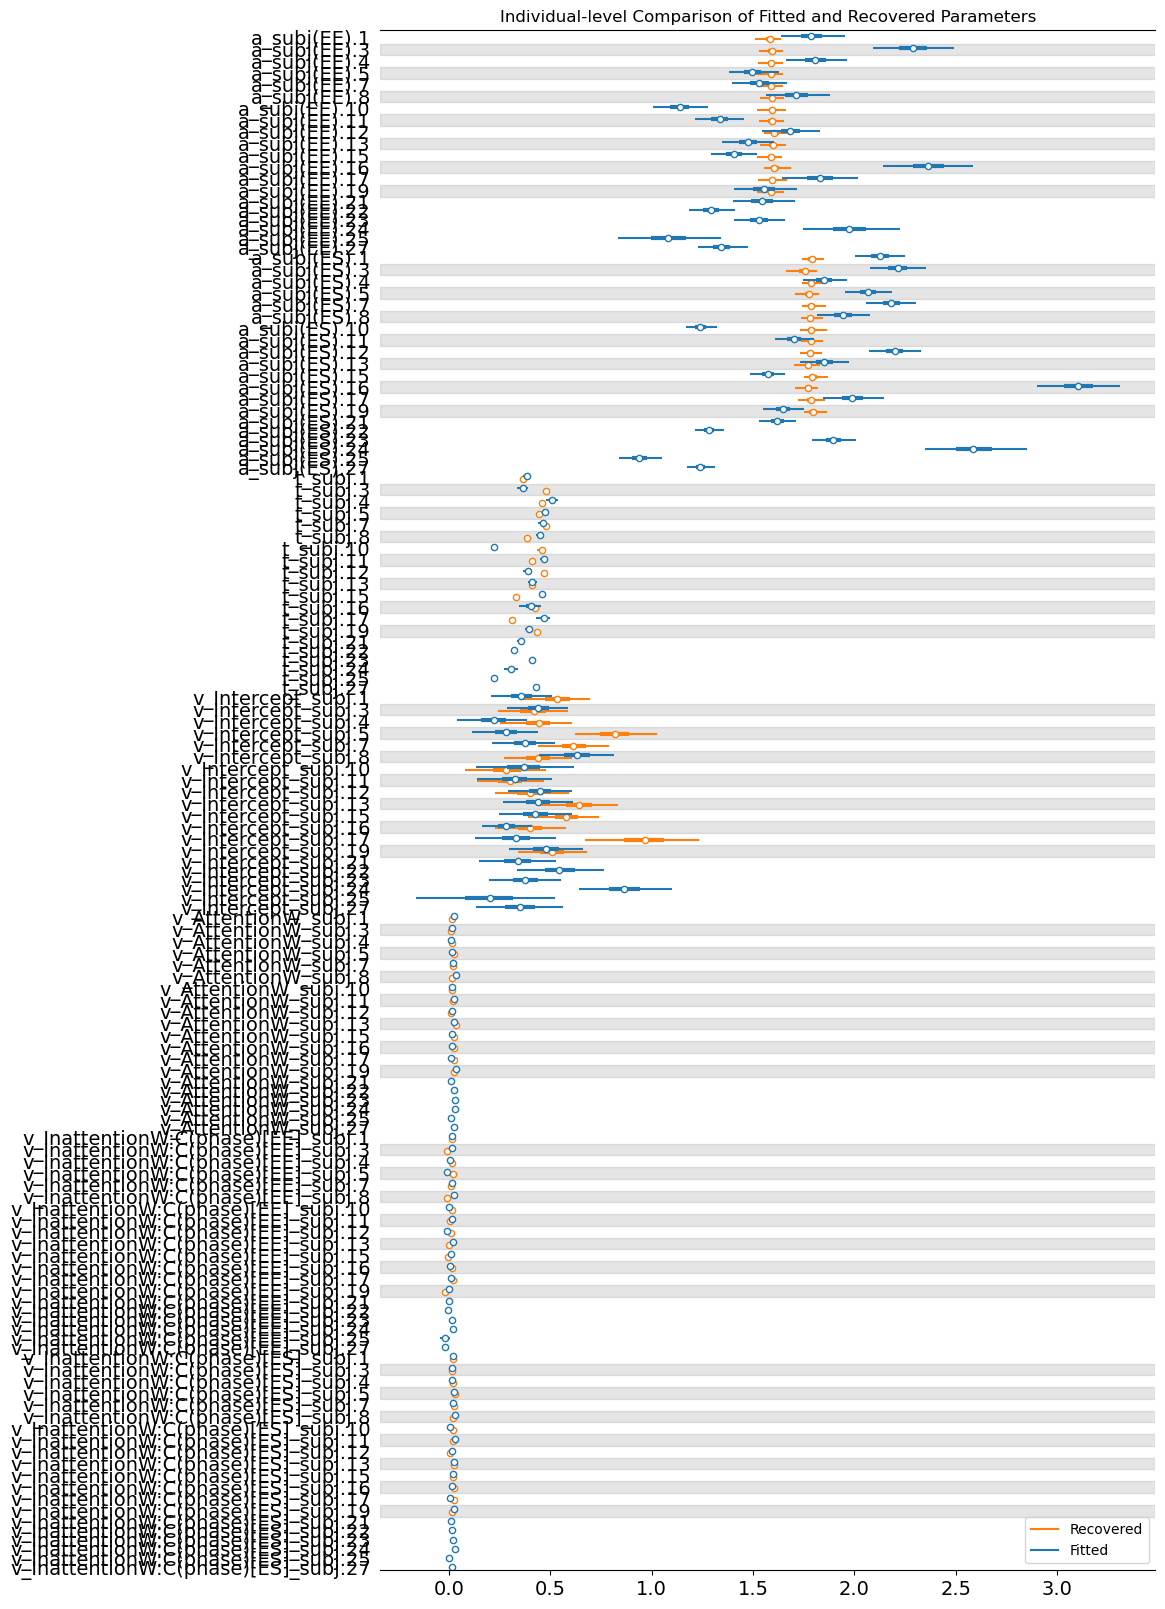

In [24]:
# subj-level forest plot
ind_param_list = [param for param in esee5_infdata.posterior.data_vars if 'subj' in param and 'std' not in param]
fig, ax = plt.subplots(figsize=(10, 20))
az.plot_forest(
    [esee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=ind_param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    hdi_prob=0.95,
    ax=ax
)
ax.set_title("Individual-level Comparison of Fitted and Recovered Parameters")
plt.show()

Columns in param_fitted:
 Index(['subj_idx', 'a(EE)', 'a(ES)', 't', 'v_AttentionW',
       'v_InattentionW:C(phase)[EE]', 'v_InattentionW:C(phase)[ES]',
       'v_Intercept'],
      dtype='object', name='param')
Columns in param_recovery:
 Index(['subj_idx', 'a(EE)', 'a(ES)', 't', 'v_AttentionW',
       'v_InattentionW:C(phase)[EE]', 'v_InattentionW:C(phase)[ES]',
       'v_Intercept'],
      dtype='object', name='param')

After filtering and aligning subjects:
Fitted shape: (14, 7)
Recovered shape: (14, 7)


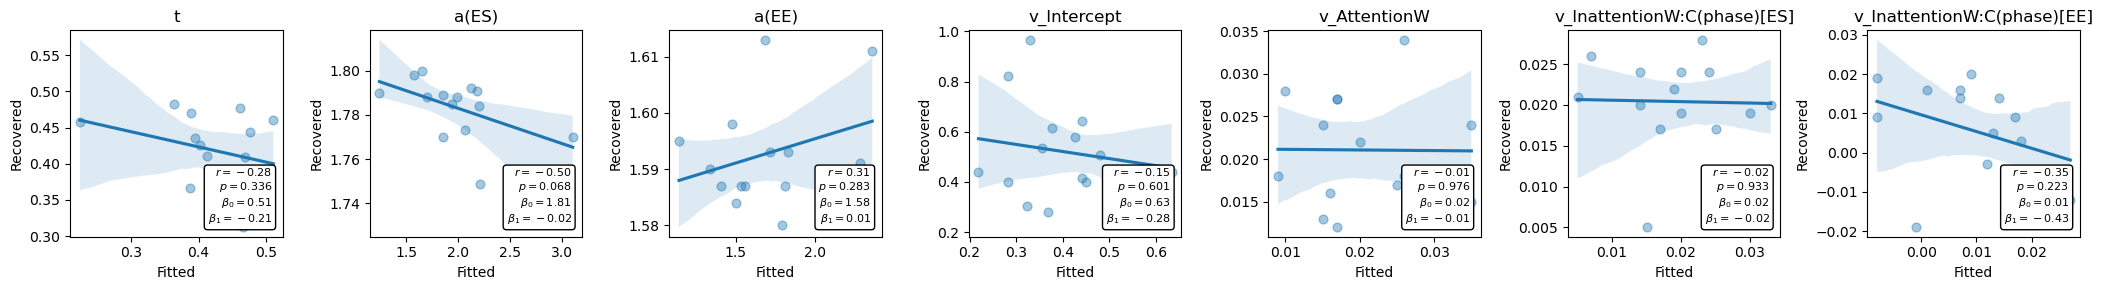

In [25]:
def regplot_with_corr(
    x, 
    y, 
    ax=None,
    cor_anonot=True,
    reg_anonot=True,
    annot_kws=None,
    scatter_kws=None
):
    """
    Scatter + regression line plot with correlation annotation
    `x` and `y` should be 1D arrays/Series of the same length
    """
    if annot_kws is None:
        annot_kws = {"fontsize": 8, "xy": (0.95, 0.05), "ha": 'right', "va": 'bottom'}
    if scatter_kws is None:
        scatter_kws = {'s': 40, "alpha": 0.4}

    if ax is None:
        ax = plt.gca()

    sns.regplot(
        x=x,
        y=y,
        ci=None if len(np.unique(y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""

    # Pearson correlation
    if cor_anonot:
        corr, pval = pearsonr(x, y)
        p_str = "p < 0.001" if pval < 0.001 else f"p = {pval:.3f}"
        annot_text += f"$r={corr:.2f}$\n${p_str}$"

    # Regression coefficients
    if reg_anonot:
        X = sm.add_constant(x)  
        model = sm.OLS(y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    if annot_text:
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
        )
    return ax


##############################################################################
# function to extract subject‐level parameters and rename them
def extract_subject_level_params(infdata):
    """
    1. Call az.summary(...) to get a DataFrame of all parameters
    2. Keep only rows that have '_subj.' in the param_name, i.e. subject-level
    3. Convert something like 't_subj(low).3' → param='t_subj(low)', subj_idx= 3
    4. Rename 't_subj(low)' -> 't(low)' so you can easily match the final names
    5. Pivot so each subject is a row, each param is a column, the value is 'mean'
    """
    # ArviZ summary
    summary_df = az.summary(infdata, kind="stats").reset_index(names="param_name")

    # Extract param vs. subject ID from param_name
    #    For example:  "t_subj(low).2" -> param="t_subj(low)", subj_idx="2"
    #    pattern: (.*)\.(\d+) to split on the last dot
    #    or  (.*)_subj\.(\d+) 
    pattern = r"(.*)\.(\d+)"
    extracted = summary_df["param_name"].str.extract(pattern)
    summary_df["param"] = extracted[0]  # e.g. "t_subj(low)"
    summary_df["subj_idx"] = extracted[1]
    
    # Keep only subject-level rows (those that have a numeric subj_idx)
    summary_df = summary_df.dropna(subset=["subj_idx"])
    summary_df["subj_idx"] = summary_df["subj_idx"].astype(int)

    # Rename e.g. "t_subj(low)"-> "t(low)" 
    #    "v_InattentionW_subj(high)" -> "v_InattentionW(high)" etc.
    #    We'll do a small replace:  param.replace("t_subj","t")
    #    Then if you also have "v_subj" or "z_subj", do similarly
    def rename_param(p):
        # e.g. "t_subj(low)" => "t(low)"
        p = p.replace("_subj", "")
        return p

    summary_df["param"] = summary_df["param"].apply(rename_param)

    # pivot so rows=subject columns=param values=mean
    pivot_df = summary_df.pivot(index="subj_idx", columns="param", values="mean").copy()
    pivot_df.reset_index(inplace=True)

    return pivot_df


#   ee5_infdata        =>  fitted model
#   m_recovery_infdata =>  recovered model

# extract subject-level parameters
param_fitted = extract_subject_level_params(esee5_infdata)
param_recovery = extract_subject_level_params(m_recovery_infdata)
print("Columns in param_fitted:\n", param_fitted.columns)
print("Columns in param_recovery:\n", param_recovery.columns)

# filter out subjects > 20 (did this because the simulations seemed to have not converged for these or not sure what exactly happened but participants simulated data looked odd)
param_fitted = param_fitted[param_fitted["subj_idx"] <= 20]
param_recovery = param_recovery[param_recovery["subj_idx"] <= 20]

# merge on subj_idx
common_subjs = set(param_fitted["subj_idx"]).intersection(set(param_recovery["subj_idx"]))
param_fitted = param_fitted[param_fitted["subj_idx"].isin(common_subjs)].set_index("subj_idx")
param_recovery = param_recovery[param_recovery["subj_idx"].isin(common_subjs)].set_index("subj_idx")


# a scaling
if "a" in param_fitted.columns and "a" in param_recovery.columns:
    param_recovery["a"] /= 2  
    print("\nAdjusted 'a' in recovery model to match fitted scale.")
print("\nAfter filtering and aligning subjects:")
print("Fitted shape:", param_fitted.shape)
print("Recovered shape:", param_recovery.shape)


param_list = [
    "t",
    "a(ES)",
    "a(EE)",
    "v_Intercept",
    "v_AttentionW",
    "v_InattentionW:C(phase)[ES]",
    "v_InattentionW:C(phase)[EE]",
]

# subplot for each param and regplot_with_corr
fig, axes = plt.subplots(ncols=len(param_list), figsize=(3*len(param_list), 3))

for i, p in enumerate(param_list):
    ax = axes[i]
    if p not in param_fitted.columns:
        print(f"Param '{p}' not in param_fitted columns!")
        ax.set_visible(False)
        continue
    if p not in param_recovery.columns:
        print(f"Param '{p}' not in param_recovery columns!")
        ax.set_visible(False)
        continue

    xvals = param_fitted[p].dropna()
    yvals = param_recovery[p].dropna()

    # Keep only the intersection of indices
    valid_idx = xvals.index.intersection(yvals.index)
    xvals = xvals.loc[valid_idx]
    yvals = yvals.loc[valid_idx]

    # if there's no data, skip
    if len(xvals) == 0:
        print(f"No valid data for param '{p}' after intersection!")
        ax.set_visible(False)
        continue
    regplot_with_corr(xvals, yvals, ax=ax)
    ax.set_xlabel("Fitted")
    ax.set_ylabel("Recovered")
    ax.set_title(p)

plt.tight_layout()
plt.show()
